## Import packages

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pydicom
from tqdm import tqdm
from skimage import data, io
from matplotlib import pyplot as plt
import ipywidgets
from ipywidgets import interact

print(f'pydicom=={pydicom.__version__}')
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'ipywidgets=={ipywidgets.__version__}')
import skimage

print(f'skimage=={skimage.__version__}')

pydicom==2.3.0
numpy==1.23.2
pandas==1.4.4
ipywidgets==8.0.2
skimage==0.19.3


## Necessary paths

In [13]:
# project path
project_path = Path.cwd().parent
# MRI data folder path
data_path = project_path/'data/dicom'
# Cardiovascular Disease file path
cvd_path = project_path/'data/csv/conditions.csv'

In [3]:
dcm_files = data_path.glob('*.dcm')
dcm_fname = dcm_files.__next__()
dcm_fname

PosixPath('/home/dk/Desktop/projects/multimodal-healthcare/mri/data/dicom/Charlette938_Runolfsson901_e8116fd7-c1a4-ddca-c425-6c63cb9ab2ec1.2.840.99999999.73920120.1192398818819.dcm')

## MRI data exploration

MRI data (after processed) will be the one modal input of the network

### Read one image and visualize

In [4]:
try:
    dcm = pydicom.dcmread(dcm_fname)
    print(type(dcm))
except FileNotFoundError:
    print ('error during file read ', dcm_fname)

<class 'pydicom.dataset.FileDataset'>


In [5]:
# convert DICOM into numerical numpy array of pixel intensity values
img = dcm.pixel_array
print(f'img shape: {img.shape}')

img shape: (256, 256, 256)


### Plotting the MRI image

Run the code below multiple times to randomly plot different slices

Plotting slice 126 of the image


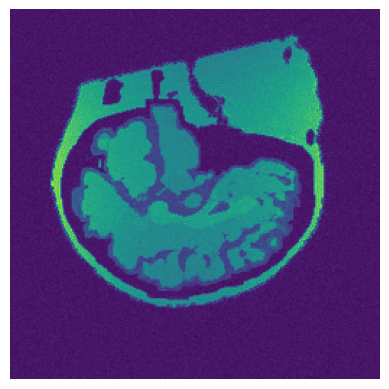

In [6]:
# Select random layer number
maxval = 255
i = np.random.randint(0, maxval)
print(f"Plotting slice {i} of the image")
plt.imshow(img[:, :, i])
plt.axis('off');

Interactive Exploration

In [7]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(5, 3))
    channel = 0
    plt.imshow(img[:, :, layer]);
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data among the depth dimension
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=127, description='layer', max=255), Output()), _dom_classes=('widget-int…

### MRI Data processing 

In [8]:
# convert uint16 datatype to float, scaled properly for uint8
# img = img.astype(float) / img.max() * 255.

# convert from float -> uint8
# img = img.astype(np.uint8)

# scale into [0, 1]
img = img.astype(float) / img.max()
img

array([[[0.06199741, 0.0509041 , 0.05099565, ..., 0.0654612 ,
         0.04499886, 0.07092393],
        [0.0684062 , 0.03550774, 0.06280613, ..., 0.09369039,
         0.05243   , 0.06990158],
        [0.05004959, 0.09262226, 0.0708629 , ..., 0.05821317,
         0.05574121, 0.0640116 ],
        ...,
        [0.06271458, 0.07055772, 0.04739452, ..., 0.05120928,
         0.07229725, 0.06263828],
        [0.06222629, 0.07486076, 0.07499809, ..., 0.05836576,
         0.0692607 , 0.0684062 ],
        [0.08513008, 0.07968261, 0.05795377, ..., 0.05156023,
         0.04112306, 0.09623865]],

       [[0.04257267, 0.06422522, 0.0527657 , ..., 0.06662089,
         0.0531014 , 0.06413367],
        [0.06845197, 0.04251164, 0.03889525, ..., 0.07064927,
         0.05723659, 0.04492256],
        [0.05944915, 0.04765393, 0.05806058, ..., 0.06172274,
         0.073579  , 0.08461128],
        ...,
        [0.07785153, 0.06062409, 0.08625925, ..., 0.08937209,
         0.06709392, 0.03436332],
        [0.0

In [9]:
# invert image if necessary, according to DICOM metadata
img_type = dcm.PhotometricInterpretation
print(img_type)

if img_type == "MONOCHROME1":
  img = np.invert(img)

MONOCHROME2


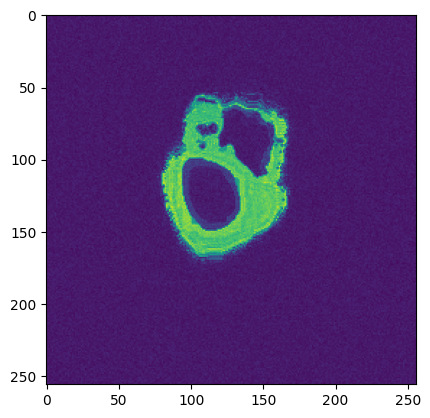

In [10]:
plt.imshow(img[:, :, 195])
plt.show()

In [11]:
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=127, description='layer', max=255), Output()), _dom_classes=('widget-int…

## Cardiovascular Disease data exloration

Cardiovascular Disease (CVD) will be the output of the network

In [16]:
df = pd.read_csv(cvd_path)
df

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1991-06-23,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,03bc904a-c655-0580-a620-264b065c01e6,162864005,Body mass index 30+ - obesity (finding)
1,2001-04-22,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,7cfc42ac-357a-c88e-1275-9d63f900b7d8,15777000,Prediabetes
2,2003-04-27,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,d3cbf195-f49a-24f5-fe79-c6dc21fb92da,271737000,Anemia (disorder)
3,1993-10-09,NaN,b8eb8d31-1031-fb5b-e207-b9815f80744c,42dbe56f-5b30-38b3-5634-a9b1a0206e44,59621000,Hypertension
4,2011-09-01,2011-09-15,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,92ad6010-058a-0362-d0df-86fcad3edf80,70704007,Sprain of wrist
...,...,...,...,...,...,...
35869,1965-11-21,NaN,3107760e-1dce-a177-4122-725241aae61a,9610387f-2967-e8b0-9494-487b83e5cae6,55822004,Hyperlipidemia
35870,1998-10-25,NaN,3107760e-1dce-a177-4122-725241aae61a,426364ce-8c69-9376-879f-bfa1f092474e,49436004,Atrial Fibrillation
35871,2001-03-11,NaN,3107760e-1dce-a177-4122-725241aae61a,647f0c30-bcdc-01e7-7392-0ac50ef428f3,230690007,Stroke
35872,2012-06-03,NaN,3107760e-1dce-a177-4122-725241aae61a,57450a36-26f1-18e1-fa9c-d7f9a01e78b6,53741008,Coronary Heart Disease


In [26]:
conditions = set(df['DESCRIPTION'])
print(f'there are {len(conditions)} different conditions, some examples are {list(conditions)[:5]}')

there are 152 different conditions, some examples are ['Hypertension', 'Antepartum eclampsia', 'Proteinuria due to type 2 diabetes mellitus (disorder)', 'Fracture of rib', 'Non-small cell carcinoma of lung  TNM stage 1 (disorder)']


In [29]:
len(set(df['PATIENT']))

3535

## References

https://github.com/mazurowski-lab/MRI-deeplearning-tutorial